# Setup

In [1]:
%matplotlib notebook
LOG_PLOT = True

## Imports

In [2]:
from matplotlib import pyplot as plt
plt.style.use('seaborn-darkgrid')
import pandas as pd
from datetime import datetime

import requests
from json import loads, dumps

import os

## ECDC Data

In [3]:

# WORLD
def fetch_world():
    response = requests.get('https://opendata.ecdc.europa.eu/covid19/casedistribution/json')    
    json = response.json()
    df = pd.read_json(dumps(json['records']))   
    df['dateRep']=pd.to_datetime(df['dateRep'].astype(str), format='%d/%m/%Y')

    return df



def plot_country(geoId, roll_days=7, log=False):
    selection = df[df.geoId==geoId].sort_values(by=['year','month','day'], ascending=True)

    f,ax = plt.subplots()
    ax.plot(selection.dateRep, selection['cases'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
#     ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(selection.dateRep, selection['cases'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    if log:
        plt.yscale('log')
        
    plt.title(selection.iloc[0].countriesAndTerritories.replace('_', ' '))
    plt.tight_layout()

    return f



df = fetch_world()


## Austria - from Gesundheitsminesterium

In [4]:
# AUSTRIA
WEEKDAYS = ('Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday')

def fetch_Austria():
    df = pd.read_csv('https://info.gesundheitsministerium.at/data/Epikurve.csv', delimiter=';')
    weekday= []
    print(df.columns)
    for i, row in df.iterrows():
        day_num = datetime.strptime(row['time'], '%d.%m.%Y').weekday()
        weekday.append(day_num)
        
    df['weekday'] = weekday
    df['time']=pd.to_datetime(df['time'].astype(str), format='%d.%m.%Y')
#     .dt.strftime('%d/%m/%Y')

    return df

def plot_Austria(roll_days=7, log=False):
    df = fetch_Austria()
    f,ax = plt.subplots()
    ax.plot(df.time, df['tägliche Erkrankungen'].rolling(roll_days).mean(), label=f'{roll_days} day average', marker='o', markersize=4, linestyle='--')
    ax.xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    ax.bar(df.time, df['tägliche Erkrankungen'],label='recorded',  alpha=0.6, color='C1')
    plt.legend(loc='best')
    plt.title('Positive COVID tests')
    if log:
        plt.yscale('log')
    plt.tight_layout()
    return f

df_at  = fetch_Austria()


Index(['time', 'tägliche Erkrankungen', 'Timestamp'], dtype='object')


## Aggregation Functions

In [48]:
import numpy as np
def rolling_avg(x):
    return np.round(x.iloc[-7:].mean())

def latest(x):
    return x.iloc[-1]

def last_7_days_sum(x):
    return x.iloc[-7:].sum()
    
    
def overview(selection):
    '''
    Returns 
    - sum,     
    - last_7_days_sum: sum in the last 7 days, 
    - rolling_avg:  rolling average for the last 7 days, 
    - latest, and 
    - max 
    values for cases and deaths
    '''
    return selection.sort_values(
        by=['year','month','day'], ascending=True).groupby("countriesAndTerritories").agg(
        {'cases': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'deaths': ['sum',  last_7_days_sum,  rolling_avg, latest,  'max' ],
        'dateRep': ['min', 'max']} ).sort_values(by= ('cases','last_7_days_sum'),ascending=False)
    

## DF Subsets

In [6]:
SELECTION =  df[df.geoId.isin(['AT', 'IN', 'US', 'UK', 'DE', 'IT', 'NL'])]
EU = df[df.continentExp=='Europe']
AMERICA = df[(df.continentExp=='America')]


# Overview

## Selected Countries

In [49]:
overview(SELECTION)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     5992532          591913       84559  88600  97894   
United_States_of_America  7078798          313836       44834  45368  78427   
United_Kingdom             429277           38919        5560   6041   6873   
Netherlands                108521           16680        2383   2711   2776   
Germany                    284140           12725        1818   1410   6294   
Italy                      308104           11535        1648   1869   6557   
Austria                     42940            4992         713    623   1141   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      94503            7751        1107   1124  2003   
United_States_of_America  204497            5239         748    723  4928   
United_Kingdom             41971             212          30     35  1224   
Netherlands                 6357              91          13     38   234   
Germany                     9457              71          10      5   315   
Italy                      35818             126          18     17   971   
Austria                      787              22           3      1    31   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-09-27  
United_States_of_America 2019-12-31 2020-09-27  
United_Kingdom           2019-12-31 2020-09-27  
Netherlands              2019-12-31 2020-09-27  
Germany                  2019-12-31 2020-09-27  
Italy                    2019-12-31 2020-09-27  
Austria                  2019-12-31 2020-09-27

## Most cases in the last 7 days

### Europe

In [51]:
overview(EU).head(5)

cases                                            \
                             sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                      
France                    527446           85252       12179  14412  16096   
Spain                     716481           76441       10920      0  31428   
Russia                   1143571           46320        6617   7523  11656   
United_Kingdom            429277           38919        5560   6041   6873   
Ukraine                   195504           22792        3256   3833   5863   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
France                   31700             426          61     39  2004   
Spain                    31232             737         105      0  1179   
Russia                   20225             886         127    169   312   
United_Kingdom           41971             212          30     35  1224   
Ukraine                   3903             387          55     76   129   

                           dateRep             
                               min        max  
countriesAndTerritories                        
France                  2019-12-31 2020-09-27  
Spain                   2019-12-31 2020-09-26  
Russia                  2019-12-31 2020-09-27  
United_Kingdom          2019-12-31 2020-09-27  
Ukraine                 2020-03-04 2020-09-27

### America

In [52]:
overview(AMERICA).head(5)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
United_States_of_America  7078798          313836       44834  45368  78427   
Brazil                    4717991          189751       27107  28378  69074   
Argentina                  702471           88826       12689  11249  17213   
Colombia                   806038           47640        6806   7721  13056   
Peru                       800142           37277        5325   5558  10143   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
United_States_of_America  204497            5239         748    723  4928   
Brazil                    141406            4874         696    869  1595   
Argentina                  15543            2838         405    335   573   
Colombia                   25296            1257         180    193   400   
Peru                       32142             773         110    105  3935   

                            dateRep             
                                min        max  
countriesAndTerritories                         
United_States_of_America 2019-12-31 2020-09-27  
Brazil                   2019-12-31 2020-09-27  
Argentina                2020-03-04 2020-09-27  
Colombia                 2020-03-07 2020-09-27  
Peru                     2020-03-07 2020-09-27

### World

In [53]:
overview(df).head(10)

cases                                            \
                              sum last_7_days_sum rolling_avg latest    max   
countriesAndTerritories                                                       
India                     5992532          591913       84559  88600  97894   
United_States_of_America  7078798          313836       44834  45368  78427   
Brazil                    4717991          189751       27107  28378  69074   
Argentina                  702471           88826       12689  11249  17213   
France                     527446           85252       12179  14412  16096   
Spain                      716481           76441       10920      0  31428   
Colombia                   806038           47640        6806   7721  13056   
Russia                    1143571           46320        6617   7523  11656   
Israel                     227100           43498        6214  11827  11827   
United_Kingdom             429277           38919        5560   6041   6873   

                          deaths                                           \
                             sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                     
India                      94503            7751        1107   1124  2003   
United_States_of_America  204497            5239         748    723  4928   
Brazil                    141406            4874         696    869  1595   
Argentina                  15543            2838         405    335   573   
France                     31700             426          61     39  2004   
Spain                      31232             737         105      0  1179   
Colombia                   25296            1257         180    193   400   
Russia                     20225             886         127    169   312   
Israel                      1441             215          31     36    71   
United_Kingdom             41971             212          30     35  1224   

                            dateRep             
                                min        max  
countriesAndTerritories                         
India                    2019-12-31 2020-09-27  
United_States_of_America 2019-12-31 2020-09-27  
Brazil                   2019-12-31 2020-09-27  
Argentina                2020-03-04 2020-09-27  
France                   2019-12-31 2020-09-27  
Spain                    2019-12-31 2020-09-26  
Colombia                 2020-03-07 2020-09-27  
Russia                   2019-12-31 2020-09-27  
Israel                   2019-12-31 2020-09-27  
United_Kingdom           2019-12-31 2020-09-27

## Lowset number of new cases in the last 7 days

### Europe*

\*among countries with population of at least 1 million

In [54]:
overview(EU[EU.popData2019>1*10**6]).tail(5)

cases                                         deaths  \
                           sum last_7_days_sum rolling_avg latest  max    sum   
countriesAndTerritories                                                         
Lithuania                 4295             631          90    111  138     89   
Serbia                   33312             472          67     74  467    746   
Kosovo                   15425             423          60     46  496    619   
Estonia                   3165             290          41     47  134     64   
Latvia                    1654             139          20     29   71     36   

                                                                  dateRep  \
                        last_7_days_sum rolling_avg latest max        min   
countriesAndTerritories                                                     
Lithuania                             2           0      0   6 2019-12-31   
Serbia                                6           1      0  18 2020-03-07   
Kosovo                                8           1      2  40 2020-03-14   
Estonia                               0           0      0   6 2019-12-31   
Latvia                                0           0      0   4 2020-03-03   

                                    
                               max  
countriesAndTerritories             
Lithuania               2020-09-27  
Serbia                  2020-09-27  
Kosovo                  2020-09-27  
Estonia                 2020-09-27  
Latvia                  2020-09-27

### America*

\*among countries with population of at least 10 million

In [55]:
overview(AMERICA[AMERICA.popData2019>1*10**7]).tail(5)


cases                                           \
                            sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                    
Guatemala                 89702            4550         650    824  4233   
Dominican_Republic       110957            3257         465    360  2147   
Bolivia                  133592            3122         446    370  2687   
Cuba                       5412             357          51     62    93   
Haiti                      8723             108          15     39   284   

                        deaths                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Guatemala                 3213             108          15     27    74   
Dominican_Republic        2093              49           7      6    39   
Bolivia                   7828             242          35     28  1610   
Cuba                       120               7           1      2     6   
Haiti                      227               6           1      0    12   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Guatemala               2020-03-15 2020-09-27  
Dominican_Republic      2019-12-31 2020-09-27  
Bolivia                 2020-03-12 2020-09-27  
Cuba                    2020-03-12 2020-09-27  
Haiti                   2020-03-20 2020-09-27

### World*
\*among countries with population of at least 10 million

In [56]:
overview( df[df.popData2019>1*10**7]).tail(5)


cases                                          \
                              sum last_7_days_sum rolling_avg latest  max   
countriesAndTerritories                                                     
Yemen                        2033               5           1      0  116   
Taiwan                        510               3           0      0   31   
Cambodia                      276               1           0      1   35   
Vietnam                      1069               1           0      0   50   
United_Republic_of_Tanzania   509               0           0      0  174   

                            deaths                                         \
                               sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                     
Yemen                          588               2           0      1  52   
Taiwan                           7               0           0      0   3   
Cambodia                         0               0           0      0   0   
Vietnam                         35               0           0      0   4   
United_Republic_of_Tanzania     21               0           0      0   6   

                               dateRep             
                                   min        max  
countriesAndTerritories                            
Yemen                       2020-04-10 2020-09-27  
Taiwan                      2019-12-31 2020-09-27  
Cambodia                    2019-12-31 2020-09-27  
Vietnam                     2019-12-31 2020-09-27  
United_Republic_of_Tanzania 2020-03-17 2020-09-27

# Austria
Compare ECDC data with Gesundheitsminesterium Data

## Total number of cases

## Last 7 days

In [59]:
df_at.agg(
        {'tägliche Erkrankungen': ['sum', last_7_days_sum,  rolling_avg, latest,  'max' ],
        'time': ['min', 'max']} )
    

,tägliche Erkrankungen,time
last_7_days_sum,4486.0,NaT
latest,477.0,NaT
max,1065.0,2020-09-27
min,NaN,2020-02-25
rolling_avg,641.0,NaT
sum,43475.0,NaT


In [60]:
overview(df[df.geoId=='AT'])

cases                                           \
                           sum last_7_days_sum rolling_avg latest   max   
countriesAndTerritories                                                   
Austria                  42940            4992         713    623  1141   

                        deaths                                         \
                           sum last_7_days_sum rolling_avg latest max   
countriesAndTerritories                                                 
Austria                    787              22           3      1  31   

                           dateRep             
                               min        max  
countriesAndTerritories                        
Austria                 2019-12-31 2020-09-27

### Weekday bias

<IPython.core.display.Javascript object>


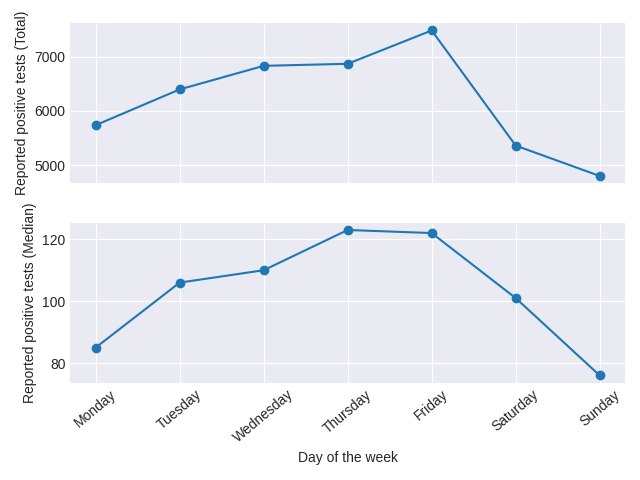

In [61]:
f, ax = plt.subplots(nrows=2, sharex=True)
df_at.groupby(['weekday']).sum()['tägliche Erkrankungen'].plot(ax=ax[0], marker='o')
ax[0].set_ylabel('Reported positive tests (Total)')
df_at.groupby(['weekday']).median()['tägliche Erkrankungen'].plot(ax=ax[1], marker='o')
ax[1].set_ylabel('Reported positive tests (Median)')
ax[1].set_xlabel('Day of the week')
ax[1].set_xticks([0,1,2,3,4,5,6])
ax[1].set_xticklabels(WEEKDAYS, rotation=40)
plt.tight_layout()

# India

<IPython.core.display.Javascript object>


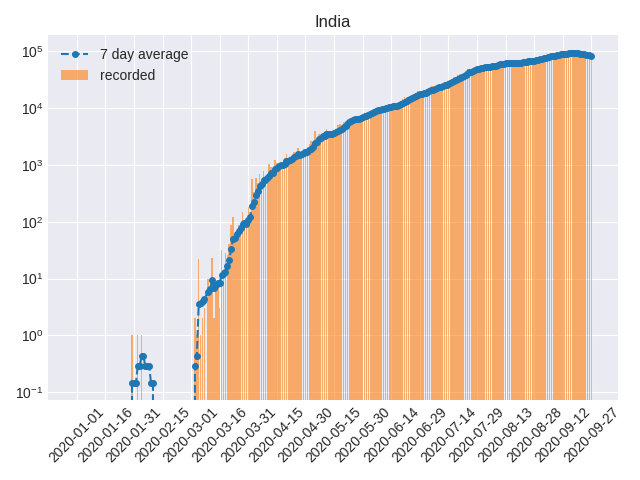

In [62]:
plot_country('IN', log=LOG_PLOT);

# USA

<IPython.core.display.Javascript object>


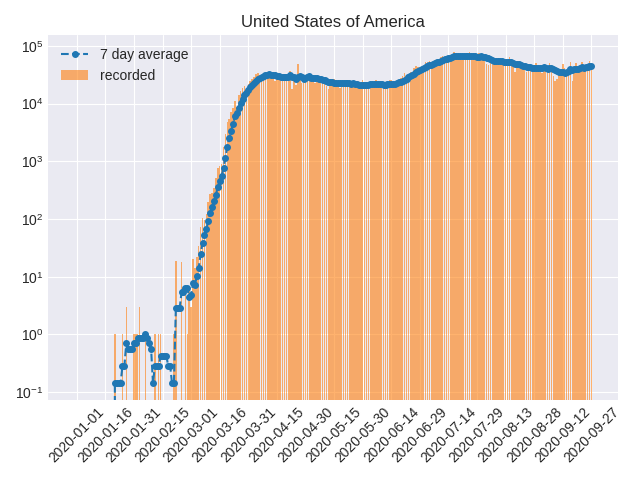

In [63]:
plot_country('US', log=LOG_PLOT);


# Germany

<IPython.core.display.Javascript object>


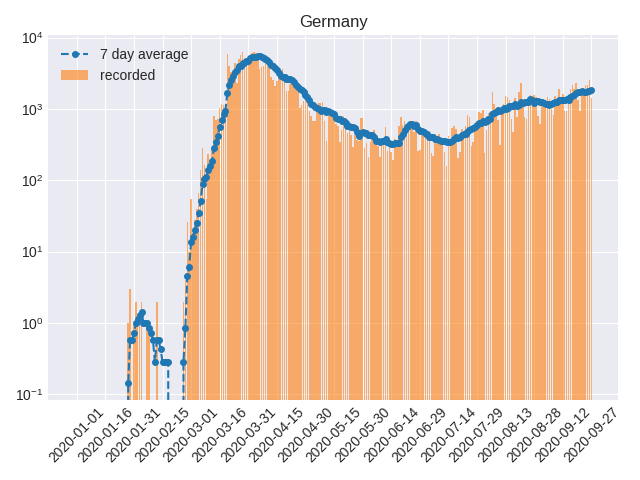

In [64]:
plot_country('DE', log=LOG_PLOT);

## UK

<IPython.core.display.Javascript object>


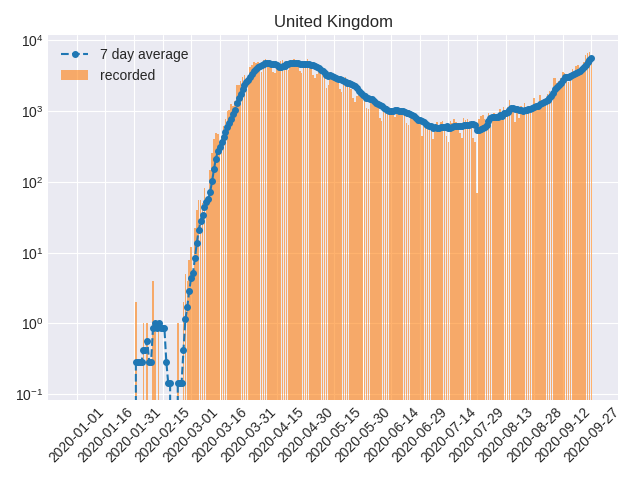

In [65]:
plot_country('UK', log=LOG_PLOT);

# China

<IPython.core.display.Javascript object>


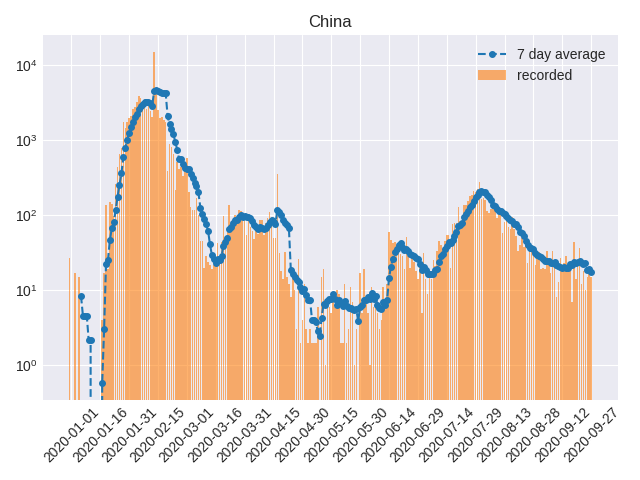

In [66]:
plot_country('CN', log=LOG_PLOT);


# Commit and Push

In [67]:
%cd Documents/code/covid19/
now = datetime.now()
commit_message = "Last run on " + now.strftime('%Y-%m-%d %H:%M')
commit_message
! echo $commit_message > commit_message.txt
! git add .
! git commit -F commit_message.txt
! git push


[Errno 2] No such file or directory: 'Documents/code/covid19/'
/home/gythaogg/Documents/code/covid19/notebooks
[develop 5fcf30e] Last run on 2020-09-28 10:26
 3 files changed, 2522 insertions(+), 195 deletions(-)
 create mode 100644 notebooks/.ipynb_checkpoints/Austria_ECDC Data Differences-checkpoint.ipynb
 create mode 100644 notebooks/Austria_ECDC Data Differences.ipynb
Enumerating objects: 10, done.
Counting objects: 100% (10/10), done.
Delta compression using up to 16 threads
Compressing objects: 100% (6/6), done.
Writing objects: 100% (6/6), 476.99 KiB | 5.55 MiB/s, done.
Total 6 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To github.com:gythaogg/covid19.git
   e8ef7d5..5fcf30e  develop -> develop
